## Swan Project Customer Retention and Churn Prediction
### By Jake D, Amanda D and Ginny R

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [2]:
# Load dataset
df = pd.read_csv('project_data.csv')

In [3]:
# Quick overview
df.head(3)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,Moved


In [4]:
# View all columns
df.columns

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Reason'],
      dtype='object')

In [5]:
# View full information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [6]:
# Check no. of unique values for each numeric column
df.select_dtypes(include='number').nunique()

Count                 1
Zip Code           1652
Latitude           1652
Longitude          1651
Tenure Months        73
Monthly Charges    1585
Churn Value           2
dtype: int64

In [7]:
# Create a working copy for safekeeping
df_clean = df.copy()

### Data Cleaning

In [8]:
# Drop irrelevant columns
drop_cols = [
    'CustomerID', 'Count', 'Country', 'State', 'City', 'Lat Long',
    'Zip Code', 'Latitude', 'Longitude', 'Churn Label', 'Churn Reason',
    'Unnamed: 31', '31', '31.1']

df_clean = df_clean.drop(columns=drop_cols, errors='ignore')

In [9]:
df_clean.columns

Index(['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months',
       'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Value'],
      dtype='object')

In [10]:
df_clean.dtypes

Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Value            int64
dtype: object

In [11]:
# Fix Total Charges by numerical conversion then fill it
df_clean['Total Charges'] = pd.to_numeric(df_clean['Total Charges'], errors='coerce').fillna(0)

In [12]:
# Check if Total Charges is a float 
df_clean.dtypes

Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges        float64
Churn Value            int64
dtype: object

## Feature Engineering

In [13]:
# Feature Engineering
df_clean['contract_payment_combo'] = df_clean['Contract'] + '_' + df_clean['Payment Method']
df_clean['streaming_no_support'] = ((df_clean['Streaming TV'] == 'Yes') & (df_clean['Tech Support'] == 'No')).astype(int)
df_clean['tenure_bucket'] = pd.cut(df_clean['Tenure Months'], bins=[0, 12, 24, 48, 72],
                             labels=['0–12', '13–24', '25–48', '49–72'])

In [14]:
## Mapping

# Binary yes/no columns
binary_cols = ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing']
for col in binary_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].map({'No': 0, 'Yes': 1})

In [15]:
# Multi-category mappings
multi_map = {
    'Multiple Lines': {'No': 0, 'Yes': 1, 'No phone service': 2},
    'Online Security': {'No': 0, 'Yes': 1, 'No internet service': 2},
    'Online Backup': {'No': 0, 'Yes': 1, 'No internet service': 2},
    'Device Protection': {'No': 0, 'Yes': 1, 'No internet service': 2},
    'Tech Support': {'No': 0, 'Yes': 1, 'No internet service': 2},
    'Streaming TV': {'No': 0, 'Yes': 1, 'No internet service': 2},
    'Streaming Movies': {'No': 0, 'Yes': 1, 'No internet service': 2}
}
for col, mapping in multi_map.items():
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].map(mapping)

In [16]:
# One-hot encoding for multi-level categories
df_clean = pd.get_dummies(df_clean, columns=['Internet Service', 'Contract', 'Payment Method'],
                    prefix=['Internet', 'Contract', 'Payment'], drop_first=True, dtype='int')

In [17]:
# Encode engineered categorical features
for col in ['contract_payment_combo', 'tenure_bucket', 'streaming_no_support']:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype('category').cat.codes

In [18]:
# Final missing value check
df_clean = df_clean.fillna(0)

In [19]:
# Check columns again
df_clean.columns

Index(['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months',
       'Phone Service', 'Multiple Lines', 'Online Security', 'Online Backup',
       'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
       'Paperless Billing', 'Monthly Charges', 'Total Charges', 'Churn Value',
       'contract_payment_combo', 'streaming_no_support', 'tenure_bucket',
       'Internet_Fiber optic', 'Internet_No', 'Contract_One year',
       'Contract_Two year', 'Payment_Credit card (automatic)',
       'Payment_Electronic check', 'Payment_Mailed check'],
      dtype='object')

In [20]:
# Retrieve 'CustomerID' if available, else generate a default ID sequence
customer_ids = df_clean['CustomerID'] if 'CustomerID' in df_clean.columns else pd.Series(np.arange(len(df_clean)), name='CustomerID')

In [21]:
# Preserve CustomerID before dropping it
df_clean_ids = df[['CustomerID']].copy()

In [22]:
# Drop ID and post-churn info, then fill blanks with 0 to avoid leakage
drop_before_model = ['CustomerID', 'Churn Reason']
for c in drop_before_model:
    if c in df_clean.columns:
        df = df_clean.drop(columns=[c])

In [23]:
# Features and target
target_col = 'Churn Value'
if target_col not in df_clean.columns:
    raise ValueError(f"Target column '{target_col}' not found in dataset.")

X = df_clean.drop(columns=[target_col])
y = df_clean[target_col].astype(int)

In [24]:
# Convert remaining object columns to categorical codes for modelling
for c in X.select_dtypes(include=['object']).columns:
    X[c] = X[c].astype('category').cat.codes

In [25]:
# Split once for both models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111, stratify=y)

## Modelling and Training

In [26]:
# Models list
models = {
    'LogisticRegression': LogisticRegression(max_iter=15000),
    'RandomForest': RandomForestClassifier(n_estimators=500, random_state=111)
}
results = []

In [27]:
# Train, evaluate, and store metrics
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):                      # Checks if model has predict_proba method
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = np.zeros_like(y_pred, dtype=float)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1s = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_prob)

    results.append({
        'model': name,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1s,
        'roc_auc': roc
    })

    print(f"{name} — Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1s:.4f} | ROC-AUC: {roc:.4f}")

LogisticRegression — Acc: 0.8240 | Prec: 0.7059 | Rec: 0.5775 | F1: 0.6353 | ROC-AUC: 0.8711
RandomForest — Acc: 0.8077 | Prec: 0.6758 | Rec: 0.5294 | F1: 0.5937 | ROC-AUC: 0.8472


In [28]:
# Results table

metrics_df = pd.DataFrame(results).sort_values(by='roc_auc', ascending=False).reset_index(drop=True)

# Format metrics as percentages with two decimal places
percent_cols = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
metrics_df[percent_cols] = metrics_df[percent_cols].multiply(100).round(2)

print("\nModel Comparison")
print(metrics_df)


Model Comparison
                model  accuracy  precision  recall     f1  roc_auc
0  LogisticRegression     82.40      70.59   57.75  63.53    87.11
1        RandomForest     80.77      67.58   52.94  59.37    84.72


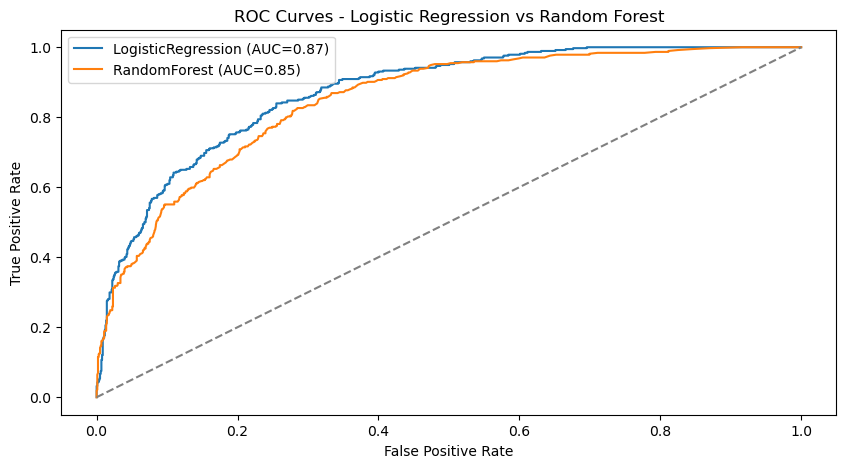

In [29]:
# Visualise ROC curves for both models
plt.figure(figsize=(10,5))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc_val = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_val:.2f})")

plt.plot([0,1],[0,1],'--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Logistic Regression vs Random Forest')
plt.legend()
plt.show()

### Prepare data for full retrain and handle NaNs

In [30]:
# Initialise imputer then fill numeric missing with 0
imputer = SimpleImputer(strategy='constant', fill_value=0)

# Fit and transform the training features
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# Define and retrain Logistic Regression
best_model = LogisticRegression(max_iter=10000, random_state=111)
best_model_name = "LogisticRegression"

# Retrain best model on full dataset
best_model.fit(X_imputed, y)
print(f"\nBest model: {best_model_name}. Retrained on full data.")


Best model: LogisticRegression. Retrained on full data.


In [31]:
# Create full output DataFrame

probs_full = best_model.predict_proba(X_imputed)[:, 1]

out_df = pd.DataFrame({
    'CustomerID': customer_ids,
    'Churn_Probability': probs_full
})

# Sort and select top 500
top_500 = out_df.sort_values(by='Churn_Probability', ascending=False).head(500).reset_index(drop=True)

# Format churn probability as percentage
top_500['Churn_Probability_%'] = (top_500['Churn_Probability'] * 100).round(2)

# Display top 10
top_500[['CustomerID', 'Churn_Probability_%']].head(10)

,CustomerID,Churn_Probability_%
0,886,87.07
1,1582,86.39
2,584,86.27
3,1382,85.29
4,716,84.78
5,1681,84.16
6,684,84.11
7,515,83.80
8,1255,83.79
9,1827,83.75


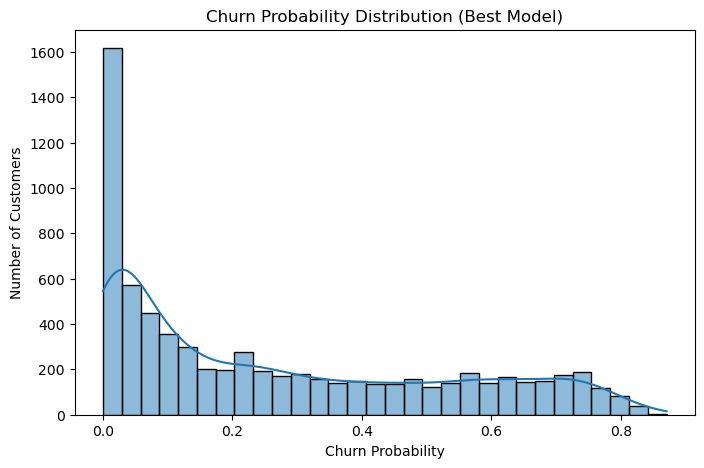

In [32]:
# Generate visuals - Probability Distribution
plt.figure(figsize=(8,5))
sns.histplot(out_df['Churn_Probability'], bins=30, kde=True)
plt.title('Churn Probability Distribution (Best Model)')
plt.xlabel('Churn Probability')
plt.ylabel('Number of Customers')
plt.show()

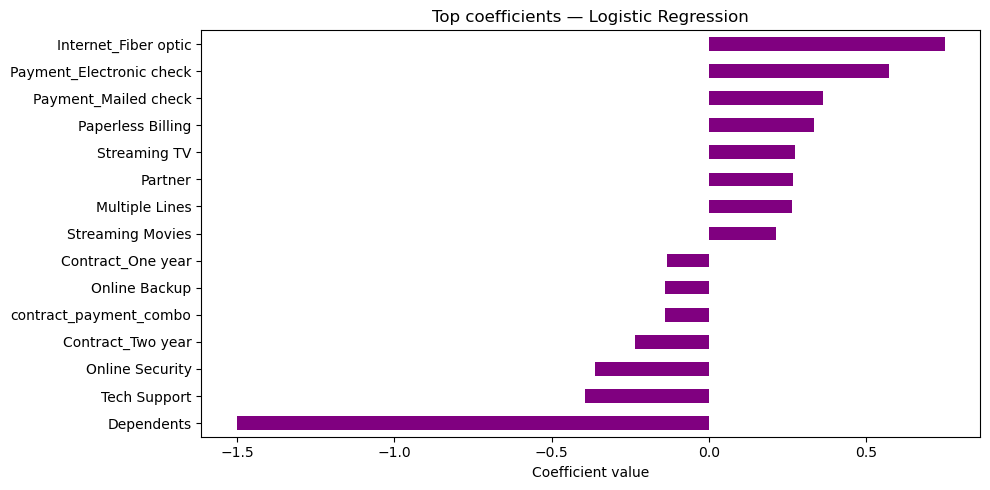

In [33]:
# Feature importance/coefficients
if hasattr(best_model, 'feature_importances_'):
    importances = pd.Series(best_model.feature_importances_, index=X.columns)
    top_feats = importances.sort_values(ascending=False).head(15)
    plt.figure(figsize=(10,5))
    top_feats.sort_values().plot(kind='barh', color='purple')
    plt.title(f'Top Features — {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
else:  # Logistic Regression
    coefs = pd.Series(best_model.coef_[0], index=X.columns).sort_values(key=abs, ascending=False).head(15)
    plt.figure(figsize=(10,5))
    coefs.sort_values().plot(kind='barh', color='purple')
    plt.title('Top coefficients — Logistic Regression')
    plt.xlabel('Coefficient value')
    plt.tight_layout()
    plt.show()

## Random Forest Visuals

In [34]:
# Train on training set only
rf_model = RandomForestClassifier(n_estimators=500, random_state=111)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf_test = rf_model.predict(X_test)
y_prob_rf_test = rf_model.predict_proba(X_test)[:, 1]

<Figure size 500x500 with 0 Axes>

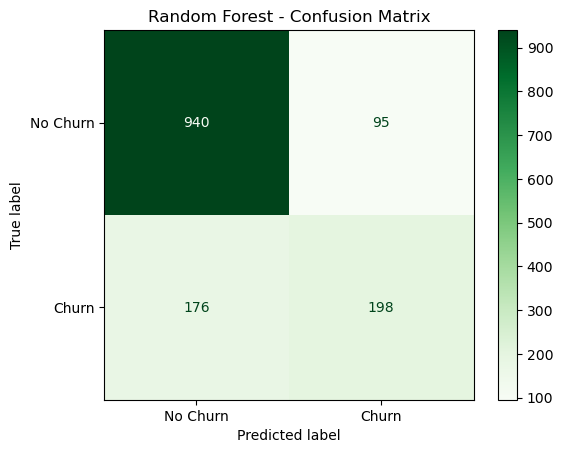

In [35]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn','Churn'])
plt.figure(figsize=(5,5))
disp.plot(cmap=plt.cm.Greens, values_format='d')
plt.title('Random Forest - Confusion Matrix')
plt.show()

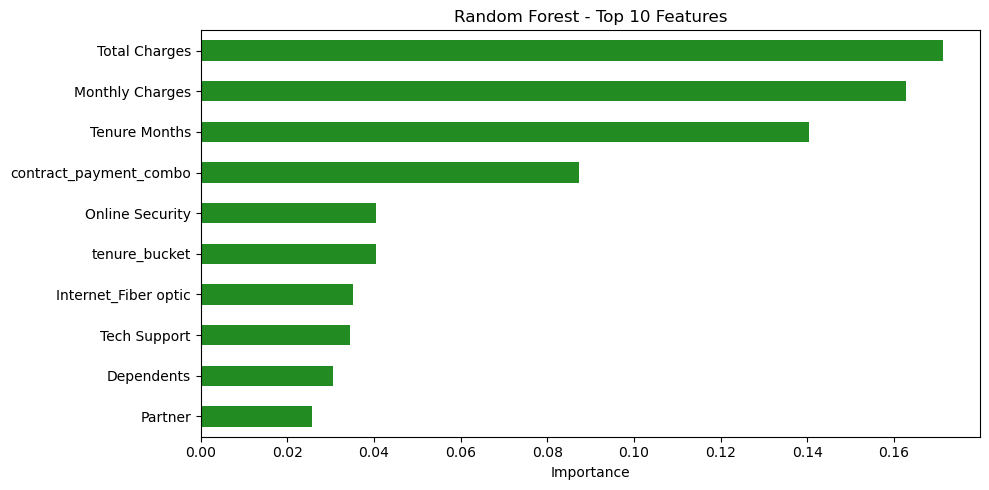

In [36]:
# Feature importance - Display top 10
importances = pd.Series(rf_model.feature_importances_, index=X_test.columns)
top_feats = importances.sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
top_feats.sort_values().plot(kind='barh', color='forestgreen')
plt.title('Random Forest - Top 10 Features')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

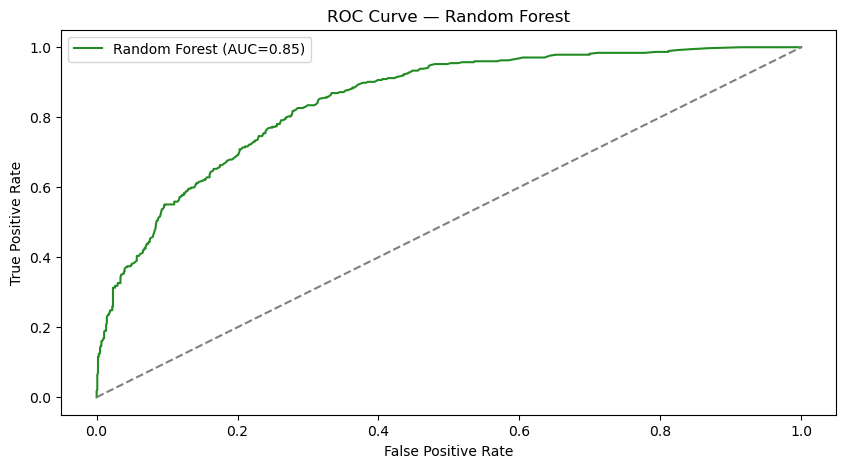

In [37]:
## Display ROC curve

fpr, tpr, _ = roc_curve(y_test, y_prob_rf_test)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(10,5))
plt.plot(fpr, tpr, label=f"Random Forest (AUC={roc_auc_val:.2f})", color='forestgreen')
plt.plot([0,1],[0,1],'--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Random Forest')
plt.legend()
plt.show()

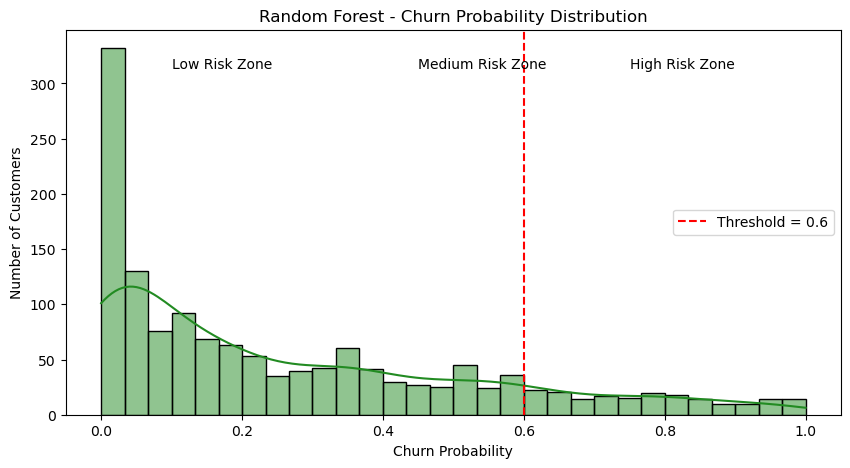

In [38]:
# Probability Distribution

plt.figure(figsize=(10,5))
sns.histplot(y_prob_rf_test, bins=30, kde=True, color='forestgreen')
# Annotate risk zones
plt.text(0.1, plt.ylim()[1]*0.9, 'Low Risk Zone', color='black', fontsize=10)
plt.text(0.45, plt.ylim()[1]*0.9, 'Medium Risk Zone', color='black', fontsize=10)
plt.text(0.75, plt.ylim()[1]*0.9, 'High Risk Zone', color='black', fontsize=10)
# Add threshold line
plt.axvline(x=0.6, color='red', linestyle='--', label='Threshold = 0.6')

plt.title('Random Forest - Churn Probability Distribution')
plt.xlabel('Churn Probability')
plt.ylabel('Number of Customers')
plt.legend()
plt.show()

In [ ]:
# Re-train Random Forest on full dataset
rf_model_full = RandomForestClassifier(n_estimators=500, random_state=111)
rf_model_full.fit(X_imputed, y)

# Reattach CustomerID from original df to cleaned df_clean
df_clean['CustomerID'] = df.loc[df_clean.index, 'CustomerID']

# Filter remaining (non-churned) customers
df_remaining = df_clean[df_clean['Churn Value'] == 0].copy()

In [ ]:
## Prepare features for scoring

# One-hot encode and align columns
X_remaining = df_remaining.drop(columns=['Churn Value'])
X_remaining_encoded = pd.get_dummies(X_remaining)
X_remaining_encoded = X_remaining_encoded.reindex(columns=X.columns, fill_value=0)
X_remaining_imputed = pd.DataFrame(imputer.transform(X_remaining_encoded), columns=X.columns)

# Score remaining customers
probs_remaining_rf = rf_model_full.predict_proba(X_remaining_imputed)[:, 1]

In [ ]:
# Create scored DataFrame
scored_df = pd.DataFrame({
    'CustomerID': df_remaining['CustomerID'].reset_index(drop=True),
    'Churn_Probability': probs_remaining_rf
})
scored_df['Churn_Probability_%'] = (scored_df['Churn_Probability'] * 100).round(2)
scored_df = scored_df[['CustomerID', 'Churn_Probability_%']].copy()

In [ ]:
# Sort and get top 500
top_500_rf = scored_df.sort_values(by='Churn_Probability_%', ascending=False).head(500).reset_index(drop=True)

In [ ]:
# Display sample of 10
top_500_rf.head(10)

In [ ]:
# Get remaining customers after top 500
remaining_rf = scored_df[~scored_df['CustomerID'].isin(top_500_rf['CustomerID'])].copy().reset_index(drop=True)
remaining_rf['Churn_Probability_%'] = remaining_rf['Churn_Probability_%'].round(2)
remaining_rf = remaining_rf[['CustomerID', 'Churn_Probability_%']].copy()

In [ ]:
# Display sample of 10
remaining_rf.head(20)

In [ ]:
# Concatenate top 500 and remaining customers
all_customers = pd.concat([top_500_rf, remaining_rf], ignore_index=True)

# Churn probability again for clarity
all_customers = all_customers.sort_values(by='Churn_Probability_%', ascending=False).reset_index(drop=True)

# Display sample of 20
all_customers.head(20)  # Use .head(n) to preview or .to_csv() to export

## Installation of Graphviz to generate Tree diagram
> Preferred method
* Download Graphviz directly from the official website for better reliability across platforms.
* Visit the official Graphviz download page: https://graphviz.org/download/
* After installation, ensure the Graphviz executables are added to your system's PATH.

> Alternative (may have issue on some systems)
* Use 'pip install graphviz'
* then verify if successfully installed with 'import graphviz'

In [ ]:
# Generate Tree

from sklearn.tree import export_graphviz
import graphviz

# Picking one tree from trained RF
estimator = rf_model_full.estimators_[0]    # Can change this later on

In [ ]:
dot_data = export_graphviz(
    estimator,
    out_file=None,
    feature_names=X_test.columns,
    class_names=['No Churn', 'Churn'],
    filled=True,
    rounded=True,
    special_characters=True,
    max_depth=5 
)

In [ ]:
# Display tree
graph = graphviz.Source(dot_data)
graph.render("rf_tree_0", format="png", view=True)  # Saves and opens the image

In [ ]:
# Export to CSV - top 500
top_500_rf.to_csv("top500_churn_risk_rf_full.csv", index=False)

In [ ]:
# Export to CSV - all existing customers
all_customers.to_csv("all_customers_rf_full.csv", index=False)